<a href="https://colab.research.google.com/github/V-Sekai-fire/meshgpt-dataset-01/blob/main/MeshGPT_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from re import T
is_train_autoencoder = True
is_train_autoencoder_iteration = True
is_train_mesh_transformer = True
is_train_mesh_transformer_iteration = False
is_clear_dataset_npz = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!yes | pip uninstall typing-extensions
!yes | pip install git+https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git
!yes | pip install -q git+https://github.com/MarcusLoppe/meshgpt-pytorch.git
!yes | pip install trimesh

Found existing installation: typing_extensions 4.9.0
Uninstalling typing_extensions-4.9.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/typing_extensions-4.9.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/typing_extensions.py
Proceed (Y/n)?   Successfully uninstalled typing_extensions-4.9.0
  Cloning https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git to /tmp/pip-req-build-z3n8pryd
  Running command git clone --filter=blob:none --quiet https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git /tmp/pip-req-build-z3n8pryd
  Resolved https://github.com/MarcusLoppe/classifier-free-guidance-pytorch.git to commit 5c189f32dbc20cd5882be4ef2a132e2aabcb8df5
  Preparing metadata (setup.py) ... done
  Using cached typing_extensions-4.9.0-py3-none-any.whl (32 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-p

In [4]:
import torch
import trimesh
import numpy as np
import os
import csv
from collections import OrderedDict

from meshgpt_pytorch import (
    MeshTransformerTrainer,
    MeshAutoencoderTrainer,
    MeshAutoencoder,
    MeshTransformer
)
from meshgpt_pytorch.data import (
    derive_face_edges_from_faces
)

In [5]:
import trimesh
import torch
import numpy as np
import os
from collections import OrderedDict

max_faces = 4096

def get_mesh(file_path):
    mesh = trimesh.load(file_path, force='mesh')

    # Center and scale vertices
    center = np.mean(mesh.vertices, axis=0)
    vertices = mesh.vertices - center
    max_abs = np.max(np.abs(vertices))
    scale_factor = (1 / 128) / max_abs
    vertices *= scale_factor

    # Quantize vertices
    vertices = np.around(vertices).astype(np.float32)

    # Sort vertices by Z, Y, X
    sorted_indices = np.lexsort(vertices.T[::-1])
    vertices = vertices[sorted_indices]

    # Map old indices to new, sorted indices
    vertex_map = np.empty(len(sorted_indices), dtype=int)
    vertex_map[sorted_indices] = np.arange(len(sorted_indices))

    # Reindex faces
    reindexed_faces = vertex_map[mesh.faces]
    sorted_faces = np.sort(reindexed_faces, axis=1)

    return vertices, sorted_faces

def augment_mesh(vertices, jitter_strength=0.01):
    jitter_amount = np.random.uniform(-jitter_strength, jitter_strength, size=vertices.shape)
    vertices += jitter_amount
    return vertices

def snake_to_sentence_case(snake_str):
    components = snake_str.split("_")
    return " ".join(word.capitalize() for word in components)

def load_filename(directory, variations):
    obj_datas = []

    # Get random scale factors within a range
    scale_factors = np.random.uniform(0.75, 1.0, size=variations)

    for filename in os.listdir(directory):
        if filename.endswith(".glb"):
            file_path = os.path.join(directory, filename)
            vertices, faces = get_mesh(file_path)

            if len(faces) > max_faces:
                print(f"Mesh {filename} has {len(faces)} faces which is more than the allowed {max_faces} faces. Rejecting.")
                continue

            faces_tensor = torch.tensor(faces, dtype=torch.long).to("cuda")
            face_edges = derive_face_edges_from_faces(faces_tensor)

            texts, _ = os.path.splitext(filename)
            texts = snake_to_sentence_case(texts)
            # Run video llava on the image. "Describe the focus of the photo as a json dictionary."
            for scale_factor in scale_factors:
                aug_vertices = augment_mesh(vertices.copy()) * scale_factor
                aug_vertices_tensor = torch.tensor(aug_vertices, dtype=torch.float)

                obj_data = {
                    "vertices": aug_vertices_tensor.to("cuda"),
                    "faces": faces_tensor,
                    "face_edges": face_edges,
                    "texts": texts
                }
                obj_datas.append(obj_data)

    print(f"[create_mesh_dataset] Returning {len(obj_datas)} meshes")
    return obj_datas


In [6]:
from pathlib import Path
import gc
import torch
import os
from meshgpt_pytorch import MeshDataset

torch.cuda.empty_cache()
gc.collect()


project_name = "demo_mesh"

working_dir = f'/content/drive/MyDrive/{project_name}'

working_dir = Path(working_dir)
working_dir.mkdir(exist_ok = True, parents = True)
dataset_path = working_dir / (project_name + ".npz")


if is_clear_dataset_npz:
    data = load_filename(working_dir, 1)
    dataset = MeshDataset(data)
    dataset.generate_face_edges()
    dataset.save(dataset_path)
else:
    dataset = MeshDataset.load(dataset_path)

print(dataset.data[0].keys())
print(set(item["texts"] for item in dataset.data)  )


[MeshDataset] Loaded 47 entrys
[MeshDataset] Created from 47 entrys
dict_keys(['vertices', 'faces', 'face_edges', 'texts'])
{'S Box', 'S Gui', 'S Primitive Wedge', 'S Chair Sofa Wide', 'S Hmd', 'S Chair Box', 'S Bed Twin', 'S Table Counter', 'S Bone', 'S Table Nightstand', 'S Chair Sofa', 'S Cabinet Dresser 03', 'Mire Clothing', 'Sk Snake 01', 'Sk Cat 01', 'S Door Single', 'S Cabinet Dresser 05', 'S Ziggurat', 'S Table Coffee', 'S Table Sit Circle', 'S Door Double', 'S Phone', 'S Door Double Frame', 'S Tree No Leaves', 'S Bed King', 'S Mask', 'S Table Bedside', 'S Primitive Cylinder Hollow', 'S Table Sit Square', 'S Chair Bar', 'S Chair Modern', 'Sk Horse 01', 'S Table Office', 'S Table Sit Rectangle', 'S Door Single Frame', 'S Primitive Sphere', 'S Stairs Single-6', 'S Table Bar Rectangle', 'S Primitive Pyramid', 'S Chair Stool Mini', 'S Cabinet Bookshelf', 'S Chair Stool', 'S Primitive Cylinder', 'S Bed Full', 'S Tree Bushy', 'S Table Bar Circle', 'S Table Bar'}


### Inspect

In [7]:
seen_texts = []  # Keep track of seen texts to avoid processing duplicates
mesh_list = []  # List to store individual meshes
translation_distance = 1.0  # Distance to translate vertices, set to 1 unit as required

# Iterate over each item in the dataset
for r, item in enumerate(dataset.data):
    texts = item['texts']

    # Skip this iteration if there are no texts or if we've already seen these texts
    if len(texts) == 0 or texts in seen_texts:
        continue

    # Add these texts to the list of seen texts
    seen_texts.append(texts)

    # Get vertices and faces
    vertices = np.array(item['vertices'].cpu())
    faces = np.array(item['faces'].cpu())

    # Translate the vertices copy
    translation_vector = np.array([len(seen_texts) * translation_distance, 0, 0])  # Translation along the x-axis
    vertices[:, :3] += translation_vector  # Apply translation only to x, y, z

    # Create a new mesh object with the translated vertices and original faces
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    # Append the new mesh to our list of meshes
    mesh_list.append(mesh)

    print(f"Iteration {r} complete. Processed {len(vertices)} vertices and {len(faces)} faces.")

# After iterating over all items, print the number of processed meshes
print(f"Total number of processed meshes: {len(mesh_list)}")


Iteration 0 complete. Processed 403 vertices and 480 faces.
Iteration 1 complete. Processed 403 vertices and 480 faces.
Iteration 2 complete. Processed 336 vertices and 168 faces.
Iteration 3 complete. Processed 264 vertices and 335 faces.
Iteration 4 complete. Processed 168 vertices and 144 faces.
Iteration 5 complete. Processed 168 vertices and 144 faces.
Iteration 6 complete. Processed 205 vertices and 320 faces.
Iteration 7 complete. Processed 216 vertices and 108 faces.
Iteration 8 complete. Processed 128 vertices and 256 faces.
Iteration 9 complete. Processed 96 vertices and 48 faces.
Iteration 10 complete. Processed 96 vertices and 48 faces.
Iteration 11 complete. Processed 62 vertices and 48 faces.
Iteration 12 complete. Processed 130 vertices and 128 faces.
Iteration 13 complete. Processed 56 vertices and 24 faces.
Iteration 14 complete. Processed 38 vertices and 44 faces.
Iteration 15 complete. Processed 38 vertices and 44 faces.
Iteration 16 complete. Processed 24 vertices a

### Train!

In [8]:
autoencoder = MeshAutoencoder().to("cuda")

**Have at least 400-2000 items in the dataset, use this to multiply the dataset**  

In [9]:
import random

random.seed(42)
random.shuffle(dataset.data)

initial_length = len(dataset.data)
if initial_length > 0:
    replication_factor = max(1, (400 - 1) // initial_length + 1)
    dataset.data *= replication_factor
    dataset.data = dataset.data[:2000]

print(len(dataset.data))

423


**Train to about 0.3 loss if you are using a small dataset**

Epoch 1/380: 100%|██████████| 52/52 [00:14<00:00,  3.57it/s, commit_loss=-.343, loss=0.203, recon_loss=0.238]


Epoch 1 average loss: 0.206714839889453 recon loss: 0.2407: commit_loss -0.3397
Stopping training at epoch 0 with average loss 0.206714839889453
Training complete


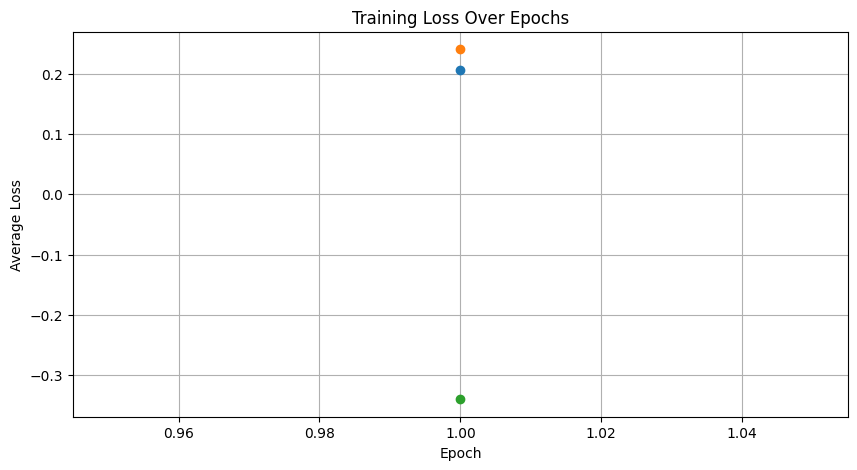

In [10]:
autoencoder_trainer = MeshAutoencoderTrainer(model = autoencoder ,warmup_steps = 10, dataset = dataset, num_train_steps=100,
                                            batch_size=8,
                                            grad_accum_every=2,
                                            learning_rate = 4e-3)
if is_train_autoencoder:
  if is_train_autoencoder_iteration:
    autoencoder_trainer.load(f'{working_dir}/mesh-encoder_{project_name}.pt')
  loss = autoencoder_trainer.train(380,stop_at_loss = 0.28, diplay_graph= True)
  autoencoder_trainer.save(f'{working_dir}/mesh-encoder_{project_name}.pt')
else:
  autoencoder_trainer.load(f'{working_dir}/mesh-encoder_{project_name}.pt')
  autencoder = autoencoder_trainer.model
  for param in autoencoder.parameters():
      param.requires_grad = True
  import gc

In [11]:
import gc
torch.cuda.empty_cache()
gc.collect()

max_length =  max(len(d["faces"]) for d in dataset if "faces" in d)
max_seq = max_length * 6
print("Highest face count:" , max_length)
print("Max token sequence:" , max_seq)

transformer = MeshTransformer(
    autoencoder,
    dim = 512,
    coarse_pre_gateloop_depth = 6, # Better performance using more gateloop layers
    fine_pre_gateloop_depth= 4,
    #attn_depth = 24, # GPT-2 medium have 24 layer depth, change if needed
    max_seq_len = max_seq,
    condition_on_text = True,
    gateloop_use_heinsen = False,
    text_condition_model_types = "bge", ## Change or remove this line if you are using:  https://github.com/MarcusLoppe/classifier-free-guidance-pytorch
    text_condition_cond_drop_prob = 0.0
)

total_params = sum(p.numel() for p in transformer.decoder.parameters())
total_params = f"{total_params / 1000000:.1f}M"
print(f"Decoder total parameters: {total_params}")
total_params = sum(p.numel() for p in transformer.parameters())
total_params = f"{total_params / 1000000:.1f}M"
print(f"Total parameters: {total_params}")

Highest face count: 4447
Max token sequence: 26682


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Decoder total parameters: 94.4M
Total parameters: 154.3M


## **Required!**, embed the text and run generate_codes to save 4-96 GB VRAM (dependant on dataset) ##

**If you don't;** <br>
During each during each training step the autoencoder will generate the codes and the text encoder will embed the text.
<br>
After these fields are generate: **they will be deleted and next time it generates the code again:**<br>

This is due to the dataloaders nature, it writes this information to a temporary COPY of the dataset


In [12]:
labels = set(item["texts"] for item in dataset.data)
print(labels)
dataset.embed_texts(transformer)
dataset.generate_codes(autoencoder)
print(dataset.data[0].keys())

{'S Gui', 'S Box', 'S Primitive Wedge', 'S Chair Sofa Wide', 'S Hmd', 'S Chair Box', 'S Bed Twin', 'S Table Counter', 'S Cabinet Dresser 03', 'S Chair Sofa', 'S Bone', 'Mire Clothing', 'Sk Cat 01', 'Sk Snake 01', 'S Table Nightstand', 'S Door Single', 'S Cabinet Dresser 05', 'S Ziggurat', 'S Table Coffee', 'S Table Sit Circle', 'S Door Double', 'S Phone', 'S Door Double Frame', 'S Tree No Leaves', 'S Mask', 'S Bed King', 'S Table Bedside', 'S Chair Bar', 'S Table Sit Square', 'S Primitive Cylinder Hollow', 'S Chair Modern', 'Sk Horse 01', 'S Table Office', 'S Table Sit Rectangle', 'S Door Single Frame', 'S Primitive Sphere', 'S Stairs Single-6', 'S Table Bar Rectangle', 'S Primitive Pyramid', 'S Chair Stool Mini', 'S Cabinet Bookshelf', 'S Chair Stool', 'S Primitive Cylinder', 'S Bed Full', 'S Tree Bushy', 'S Table Bar Circle', 'S Table Bar'}
[MeshDataset] Generated 47 text_embeddings
[MeshDataset] Generated codes for 423 entrys
dict_keys(['vertices', 'faces', 'face_edges', 'text_embed

*Load previous saved model if you had to restart session*

**Train to about 0.0001 loss (or less) if you are using a small dataset**

In [13]:
if not is_train_mesh_transformer:
  trainer = MeshTransformerTrainer(model = transformer, warmup_steps = 10,grad_accum_every=1,num_train_steps=100, dataset = dataset, learning_rate = 1e-1, batch_size=1)
  trainer.load(f'{working_dir}/mesh-transformer_{project_name}.pt')
  transformer = trainer.model
else:
  trainer = MeshTransformerTrainer(model = transformer,warmup_steps = 10,grad_accum_every=4,num_train_steps=100, dataset = dataset,
                                 learning_rate = 5e-4, batch_size=2)
  if is_train_mesh_transformer_iteration:
    trainer.load(f'{working_dir}/mesh-transformer_{project_name}.pt')
  loss = trainer.train(200, stop_at_loss = 0.00001)

Epoch 1/200:  23%|██▎       | 48/211 [00:25<01:26,  1.89it/s, loss=9.48]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.26 GiB. GPU 0 has a total capacty of 39.56 GiB of which 2.03 GiB is free. Process 81437 has 37.52 GiB memory in use. Of the allocated memory 29.02 GiB is allocated by PyTorch, and 7.98 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

**Load the latest model**

In [ ]:
autoencoder_trainer = MeshAutoencoderTrainer(model = autoencoder ,warmup_steps = 10, dataset = dataset, num_train_steps=100, batch_size=8,  grad_accum_every=1, learning_rate = 1e-4)
autoencoder_trainer.load(f'{working_dir}/mesh-encoder_{project_name}.pt')
autencoder = autoencoder_trainer.model
for param in autoencoder.parameters():
    param.requires_grad = True
import gc
torch.cuda.empty_cache()
gc.collect()

max_length =  max(len(d["faces"]) for d in dataset if "faces" in d)
max_seq = max_length * 6
print("Highest face count:" , max_length)
print("Max token sequence:" , max_seq)

transformer = MeshTransformer(
    autoencoder,
    dim = 512,
    coarse_pre_gateloop_depth = 6, # Better performance using more gateloop layers
    fine_pre_gateloop_depth= 4,
    # attn_depth = 24, # GPT-2 medium have 24 layer depth, change if needed
    max_seq_len = max_seq,
    condition_on_text = True,
    gateloop_use_heinsen = False,
    text_condition_model_types = "bge", ## Change or remove this line if you are using:  https://github.com/MarcusLoppe/classifier-free-guidance-pytorch
    text_condition_cond_drop_prob = 0.0
).to("cuda")

trainer = MeshTransformerTrainer(model = transformer,warmup_steps = 10,grad_accum_every=1,num_train_steps=100, dataset = dataset, learning_rate = 1e-1, batch_size=2)
trainer.load(f'{working_dir}/mesh-transformer_{project_name}.pt')
transformer = trainer.model


## Generate and view mesh

In [ ]:
trainer.save(f'{working_dir}/mesh-transformer_{project_name}.pt')

In [ ]:
def combind_mesh(path, mesh):
    all_vertices = []
    all_faces = []
    vertex_offset = 0
    translation_distance = 0.5

    for r, faces_coordinates in enumerate(mesh):
        numpy_data = faces_coordinates[0].cpu().numpy().reshape(-1, 3)

        for vertex in numpy_data:
            all_vertices.append(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

        for i in range(1, len(numpy_data), 3):
            all_faces.append(f"f {i + vertex_offset} {i + 1 + vertex_offset} {i + 2 + vertex_offset}\n")

        vertex_offset += len(numpy_data)

    obj_file_content = "".join(all_vertices) + "".join(all_faces)

    with open(path , "w") as file:
        file.write(obj_file_content)

def combind_mesh_with_rows(path, meshes):
    all_vertices = []
    all_faces = []
    vertex_offset = 0
    translation_distance = 0.5

    for row, mesh in enumerate(meshes):
        for r, faces_coordinates in enumerate(mesh):
            numpy_data = faces_coordinates[0].cpu().numpy().reshape(-1, 3)
            numpy_data[:, 0] += translation_distance * (r / 0.2 - 1)
            numpy_data[:, 2] += translation_distance * (row / 0.2 - 1)

            for vertex in numpy_data:
                all_vertices.append(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

            for i in range(1, len(numpy_data), 3):
                all_faces.append(f"f {i + vertex_offset} {i + 1 + vertex_offset} {i + 2 + vertex_offset}\n")

            vertex_offset += len(numpy_data)

        obj_file_content = "".join(all_vertices) + "".join(all_faces)

    with open(path , "w") as file:
        file.write(obj_file_content)


def write_mesh_output(path, coords):
    numpy_data = faces_coordinates[0].cpu().numpy().reshape(-1, 3)
    obj_file_content = ""

    for vertex in numpy_data:
        obj_file_content += f"v {vertex[0]} {vertex[1]} {vertex[2]}\n"

    for i in range(1, len(numpy_data), 3):
        obj_file_content += f"f {i} {i + 1} {i + 2}\n"

    with open(path, "w") as file:
        file.write(obj_file_content)


**Using only text**

In [ ]:

from pathlib import Path

folder = working_dir / 'renders'
obj_file_path = Path(folder)
obj_file_path.mkdir(exist_ok = True, parents = True)

text_coords = []
for text in labels:
    print(f"Generating {text}")
    faces_coordinates = transformer.generate(texts = [text],  temperature = 0.0)
    text_coords.append(faces_coordinates)

    write_mesh_output(f'{folder}/3d_output_{text}.obj', faces_coordinates)


combind_mesh(f'{folder}/3d_models_all.obj', text_coords)

**Text + prompt of tokens**

Grab fresh copy of dataset

In [ ]:
dataset = MeshDataset.load(dataset_path)
dataset.generate_codes(autoencoder)

**Prompt with 10% of codes/tokens**

In [ ]:
from pathlib import Path
token_length_procent = 0.10
codes = []
texts = []
for label in labels:
    for item in dataset.data:
        if item['texts'] == label:
            num_tokens = int(item["codes"].shape[0] * token_length_procent)

            texts.append(item['texts'])
            codes.append(item["codes"].flatten()[:num_tokens].unsqueeze(0))
            break

folder = working_dir / f'renders/text+codes'
obj_file_path = Path(folder)
obj_file_path.mkdir(exist_ok = True, parents = True)

coords = []



for text, prompt in zip(texts, codes):
    print(f"Generating {text} with {prompt.shape[1]} tokens")
    faces_coordinates = transformer.generate(texts = [text],  prompt = prompt, temperature = 0)
    coords.append(faces_coordinates)

    obj_file_path = f'{folder}/{text}_{prompt.shape[1]}_tokens.obj'
    write_mesh_output(obj_file_path, faces_coordinates)

    print(obj_file_path)


combind_mesh(f'{folder}/text+prompt_all.obj', coords)

if text_coords is not None:
    combind_mesh_with_rows(f'{folder}/both_verisons.obj', [text_coords , coords])

**Prompt with 0% to 80% of tokens**

In [ ]:
import json
import numpy as np
import trimesh
from pathlib import Path

def convert_to_obj(vertices, faces, output_file_path):
    scene = trimesh.Scene()
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    scene.add_geometry(mesh)

    with open(output_file_path, "w") as f:
        f.write(scene.export(file_type="obj"))

def encode_to_pua(codes):
    flat_codes = [item for sublist in codes for subsublist in sublist for item in subsublist]
    return "".join(chr(code + 0xF0000) for code in flat_codes)

jsonl_lines = []

for token_length_procent in np.arange(0, 0.8, 0.1):
    codes = []
    texts = []
    for label in labels:
        for item in dataset.data:
            if item['texts'] == label:
                num_tokens = int(item["codes"].shape[0] * token_length_procent)

                texts.append(item['texts'])
                codes.append(item["codes"].flatten()[:num_tokens].unsqueeze(0))
                break

    coords = []
    for text, code in zip(texts, codes):
        print(f"Generating {text} with {code.shape[1]} tokens")
        faces_coordinates = transformer.generate(texts=[text], prompt=code, temperature=0)
        coords.append(faces_coordinates)

        # Process mesh data inlined here
        continuous_coors_list = [np_array.tolist() for np_array in faces_coordinates]
        flat_list = [item for sublist in continuous_coors_list for item in sublist]
        vertices = [vertex for sublist in flat_list for vertex in sublist]
        faces = [[i, i + 1, i + 2] for i in range(0, len(vertices), 3)]

        obj_filename = f'{text}_{code.shape[1]}_tokens.obj'
        obj_file_path = folder / obj_filename
        convert_to_obj(vertices, faces, obj_file_path)

        encoded_codes = encode_to_pua(code.cpu().tolist())

        with open(obj_file_path, "r") as file:
            obj_contents = file.read()

        # Append line to JSONL structure
        jsonl_line = [
            {"role": "system", "content": "This assistant can understand 3D models using the meshgpt-pytorch Unicode plane 15 codebook for 16384 triangles and the .obj 3d format."},
            {"role": "user", "content": encoded_codes},
            {"role": "assistant", "content": obj_contents}
        ]
        jsonl_lines.append(jsonl_line)

        print(obj_file_path)

    mesh_rows.append(coords)
    combind_mesh(f'{folder}/text+prompt_all_{token_length_procent}.obj', coords)

combind_mesh_with_rows(f'{folder}/all.obj', mesh_rows)

with open("chatml.jsonl", "w", encoding="utf-8") as f:
    for item in jsonl_lines:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")